# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
import numpy as np
import seaborn as sns

In [2]:
ALL_POINTS = 500
MAX_POINTS = 200
BUDGET = 10_000_000_000
PRICE_FOR_1000_BARRELS = 450_000
RANDOM = RandomState(12345) 
STATE=12345

Загрузим данные для трех локаций

In [3]:
geo_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Посмотрим на данные

In [4]:
geo_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
geo_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
geo_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
geo_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
geo_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


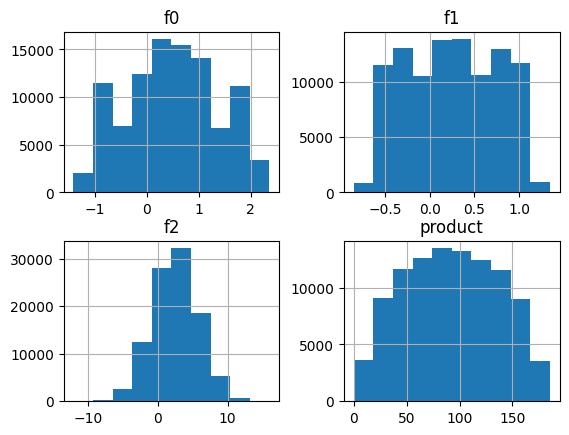

In [13]:
geo_1.hist();

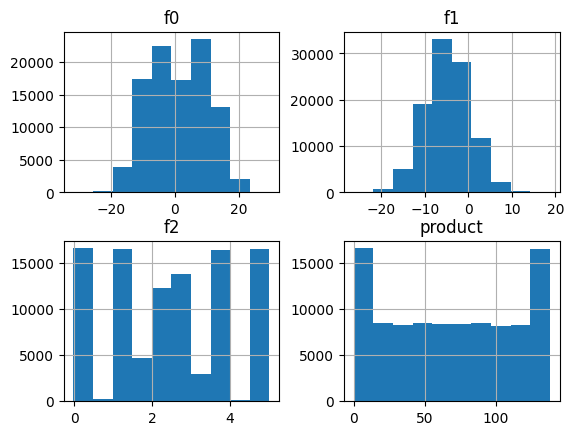

In [14]:
geo_2.hist();

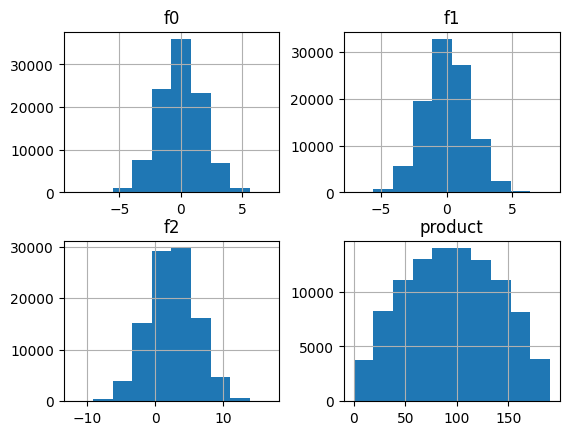

In [15]:
geo_3.hist();

Данные представлены в одном масштабе. Пропусков в данных нет, распределения данных без выпадающих значений. Проверим наличие явных дубликатов.

In [16]:
geo_1.duplicated().sum()

0

In [17]:
geo_2.duplicated().sum()

0

In [18]:
geo_3.duplicated().sum()

0

Явных дубликатов нет. Проверим дубликаты по id и уберем при наличии.

In [19]:
geo_1['id'].duplicated().sum()

10

In [20]:
geo_1 = geo_1.drop_duplicates(subset='id', keep='first')

In [21]:
geo_2['id'].duplicated().sum()

4

In [22]:
geo_2 = geo_2.drop_duplicates(subset='id', keep='first')

In [23]:
geo_3['id'].duplicated().sum()

4

In [24]:
geo_3 = geo_3.drop_duplicates(subset='id', keep='first')

Проанализируем данные на наличие мультиколлинеарности

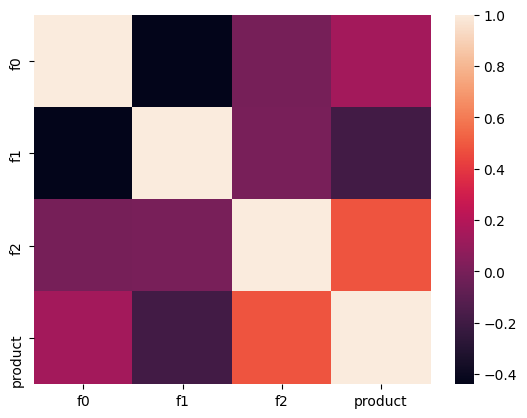

In [25]:
sns.heatmap(geo_1.corr());

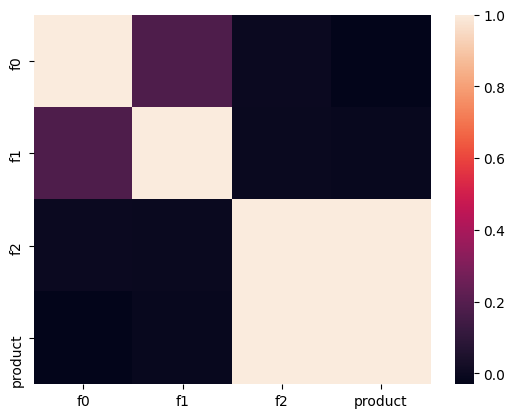

In [26]:
sns.heatmap(geo_2.corr());

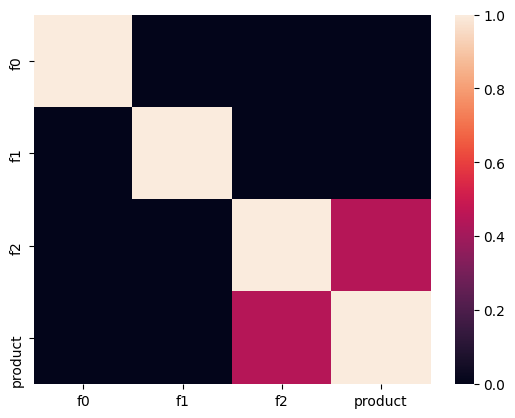

In [27]:
sns.heatmap(geo_3.corr());

Исходя из анализа корреляции, сильно влияет на целевой признак только f2 (кроме geo_0).

Итог: Данные в одном масштабе, без пропусков, небольшое количество дубликатов удалено, f2 и целевой признак коллинеарны

## Обучение и проверка модели

Выделим целевой признак

In [28]:
target_1 = geo_1['product']
target_2 = geo_2['product']
target_3 = geo_3['product']

In [29]:
features_1 = geo_1.drop(labels=['id', 'product'], axis=1)
features_2 = geo_2.drop(labels=['id', 'product'], axis=1)
features_3 = geo_3.drop(labels=['id', 'product'], axis=1)

Напишем функцию, которая будет предсказывать данные по месторождениям

In [30]:
def prediction(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=STATE)
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    mse = mean_squared_error(target_valid, prediction)
    return target_valid, prediction, mse

In [31]:
target_valid_1, prediction_1, mse_1 = prediction(features_1, target_1)
target_valid_2, prediction_2, mse_2 = prediction(features_2, target_2)
target_valid_3, prediction_3, mse_3 = prediction(features_3, target_3)

In [32]:
print('geo_0, средний запас сырья:', prediction_1.mean(), 'RMSE модели:', mse_1**0.5)
print('geo_1, средний запас сырья:', prediction_2.mean(), 'RMSE модели:', mse_2**0.5)
print('geo_2, средний запас сырья:', prediction_3.mean(), 'RMSE модели:', mse_3**0.5)

geo_0, средний запас сырья: 92.78915638280621 RMSE модели: 37.853527328872964
geo_1, средний запас сырья: 69.1783195703043 RMSE модели: 0.8920592647717026
geo_2, средний запас сырья: 94.86572480562035 RMSE модели: 40.07585073246016


Итог: Наименьший квадрат средней квадратичной ошибки для geo_1, значит, предсказания модели также точнее всего для этой локации. Средний запас сырья заметно больше для geo_0 и geo_2.

## Подготовка к расчёту прибыли

Как я понимаю, для того, чтобы бюджет на локацию окупился, нужно, чтобы доход от продажи перекрыл расход, исходя из этого, минимальное количество баррелей:

In [33]:
minimum_barrels = BUDGET/PRICE_FOR_1000_BARRELS/MAX_POINTS
print('Минимальное кол-во тысяч бареллей: ',minimum_barrels)

Минимальное кол-во тысяч бареллей:  111.11111111111111


Напишем функции для расчета прибыли, доверительного интервала и вероятности убытка для локаций

In [34]:
def profit(target, predict):
    predict_sorted = predict.sort_values(ascending=False)
    target_sorted = target[predict_sorted.index][:200]
    product = target_sorted.sum()
    return product * PRICE_FOR_1000_BARRELS - BUDGET 

In [35]:
def bootstrap(target_valid, prediction, iterations):
    values = []
    target_valid = target_valid.reset_index(drop=True)
    
    for i in range(iterations):
        prediction = pd.Series(prediction)
        prediction_subsample = prediction.sample(n=500, replace=True, random_state=RANDOM)
        target_subsample = target_valid[prediction_subsample.index]
        
        values.append(profit(target_subsample, prediction_subsample))
    values = pd.Series(values)
    return values

In [36]:
def profitability(target_valid, prediction, iterations):
    values = bootstrap(target_valid, prediction, iterations)
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    lesion = values[values < 0].count()
    lesion_probability = lesion / values.count()
    return mean, lower, upper, lesion_probability  

## Расчёт прибыли и рисков 

При помощи наших функций рассчитаем значений для каждой локации

In [37]:
mean_1, lower_1, upper_1, lesion_probability_1 = profitability(target_valid_1, prediction_1, 1000)
mean_2, lower_2, upper_2, lesion_probability_2 = profitability(target_valid_2, prediction_2, 1000)
mean_3, lower_3, upper_3, lesion_probability_3 = profitability(target_valid_3, prediction_3, 1000)

In [38]:
print('geo_0, средняя прибыль:', mean_1)
print('Нижняя граница доверительного интервала:', lower_1)
print('Верхняя граница доверительного интервала:', upper_1)
print('Вероятность убытка, %', lesion_probability_1*100)

geo_0, средняя прибыль: 409428038.62143606
Нижняя граница доверительного интервала: -131536028.70166382
Верхняя граница доверительного интервала: 944395582.7546725
Вероятность убытка, % 7.1


In [39]:
print('geo_1, средняя прибыль:', mean_2)
print('Нижняя граница доверительного интервала:', lower_2)
print('Верхняя граница доверительного интервала:', upper_2)
print('Вероятность убытка, %', lesion_probability_2*100)

geo_1, средняя прибыль: 536400199.43510306
Нижняя граница доверительного интервала: 112954247.12370124
Верхняя граница доверительного интервала: 998504156.6468805
Вероятность убытка, % 0.3


In [40]:
print('geo_2, средняя прибыль:', mean_3)
print('Нижняя граница доверительного интервала:', lower_3)
print('Верхняя граница доверительного интервала:', upper_3)
print('Вероятность убытка, %', lesion_probability_3*100)

geo_2, средняя прибыль: 339478034.1977997
Нижняя граница доверительного интервала: -224089221.7440758
Верхняя граница доверительного интервала: 847067587.6863929
Вероятность убытка, % 11.799999999999999


In [41]:
all_profit = [mean_1, mean_2, mean_3]
print(max(all_profit))

536400199.43510306


Риск убытка для локаций geo_0 и geo_2 превышает 2,5%, вероятность убытка для geo_1 равна 0,3% (<2,5%).Самое высокое значение средней прибыли также наблюдается для geo_1. 

Общий итог: 
- Основное влияние на целевой признак оказывает признак "f2"
- Обучена модель линейной регрессии, наименьшая ошибка модели наблюдается для geo_1, наибольшее количество запасов - для geo_2
- Рассчитан минимальный запас баррелей, нобходимый для покрытия бюджета
- Написаны функции для определения прибыли и риска убытка по предсказаниям модели
- Единственная локация, где риск убытка <2,5% - это geo_1, она же имеет самое высокое значение средней прибыли
- Исходя минимальной ошибки модели, минимальной вероятности убытка и высокого значения средней прибыли, geo_1 - лучший регион для разработки месторождения